In [58]:
import numpy as np
import pyamg
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
import os

import pandas as pd
import scipy

%matplotlib inline

In [59]:
def cg(A, b):
    return pyamg.krylov.cg(A, b, tol=1e-8, maxiter=min(A.shape[0],1000))[0]

def mg(A, b):
    return pyamg.ruge_stuben_solver(A).solve(b, tol=1e-8)

def sd(A, b):
    return pyamg.krylov.steepest_descent(A, b, tol=1e-8)[0]

def gmres(A, b):
    return pyamg.krylov.gmres(A, b, tol=1e-8, maxiter=min(A.shape[0],1000))[0]

methods = [("CG",cg), ("MG",mg), ("SD", sd), ("GMRES", gmres)]

scales = [1e-7, 
          1e-6,  
          1e-5, 
          1e-4, 
          1e-3,]

runs_per = 1


files = [f for f in os.listdir('.') if os.path.isfile(f) and '.mat' in f]


In [49]:
for f_i, f in enumerate(files):
    if 'BCS' not in f:
        continue
    temp_data = []
    mat_data = scipy.io.loadmat(f)
    A = mat_data[list(mat_data.keys())[-1]]
    print("Matrix: {} N: {}".format(f, A.shape[0]))

Matrix: BCSSTK17.mat N: 10974
Matrix: BCSSTK16.mat N: 4884
Matrix: BCSSTK14.mat N: 1806
Matrix: BCSSTK15.mat N: 3948
Matrix: BCSSTK18.mat N: 11948


results_df = pd.DataFrame(columns=['Method','matrix','N','sigma','run',
                                   'Residual Norm 1', 'Residual Norm 2'])

for f_i, f in enumerate(files):
    temp_data = []
    mat_data = scipy.io.loadmat(f)
    A = mat_data[list(mat_data.keys())[-1]]
    print("Matrix: {} N: {}".format(f_i, A.shape[0]))
    
    if (A.shape[0] > 12000 or 'BCS' not in f):
        continue
        
    for scale_i in range(len(scales)):
        print("    Scale: ", scale_i)

        for run_i in range(runs_per):
            b = np.random.rand(A.shape[0])
            E = scipy.sparse.csr_matrix(np.random.normal(scale=scales[scale_i], size=(A.shape[0],A.shape[1]))).multiply(A!=0)
            Ap = A + E
            
            E2 = np.random.normal(scale=scales[scale_i], size=(b.shape))
            bp = b + A @ E2
            
            for method_i in range(len(methods)):
                name, solver = methods[method_i]
                print("        Method: ", name)
                x = solver(A, b)
                xp = solver(Ap, b)
                xp2 = solver(A, bp)

                temp_data.append({
                    'Method':name,
                    'matrix':f,
                    'N':A.shape[0],
                    'sigma':scales[scale_i],
                    'run':run_i,
                    'Residual Norm 1': np.linalg.norm(x - xp),
                    'Residual Norm 2': np.linalg.norm(x - xp2 + E2),
                })

    results_df = results_df.append(temp_data)

In [52]:
results_df.to_csv('Poisson_Applications.csv')

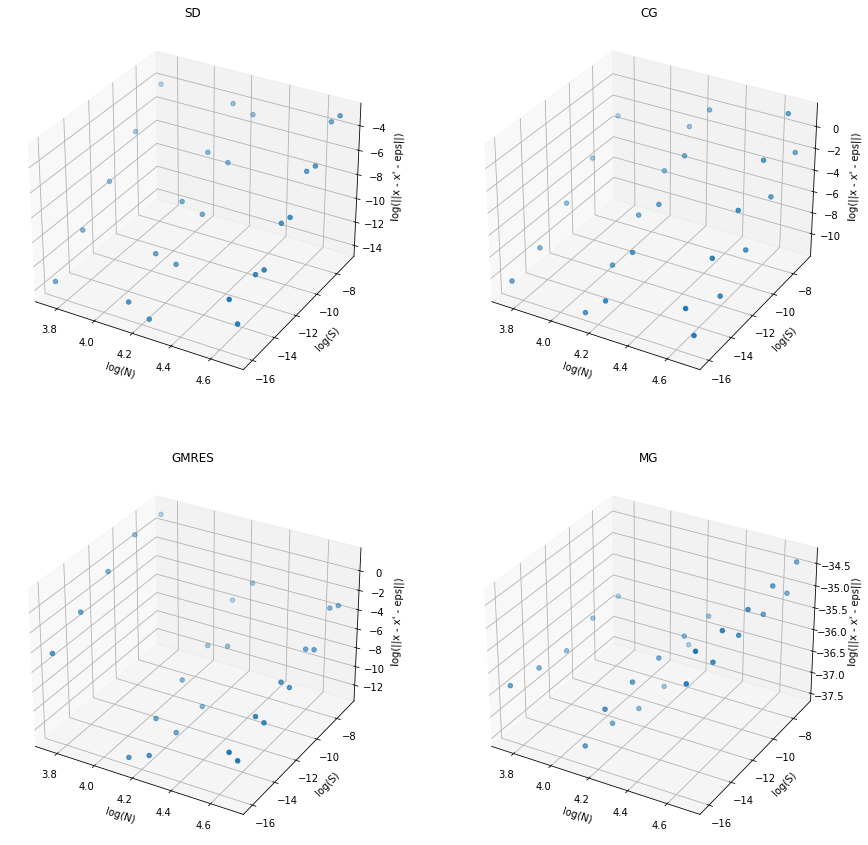

In [74]:
methods = [('SD',1),('CG',2),('GMRES',3),('MG',4)]

target = ['Residual Norm 2']
features = ['N','sigma']

fig = plt.figure(figsize=(15,15))

for name, index in methods:
    method_results = results_df[results_df['Method']==name]

    X = method_results.loc[:,features]
    Y = method_results.loc[:,target]

#    reg = LinearRegression(normalize=True).fit(np.log(X), np.log(Y))
#    reg.score(np.log(X), np.log(Y)), reg.coef_, reg.intercept_
    
    ax = fig.add_subplot(2, 2, index, projection='3d')
    ax.set_title(name)
    ax.set_xlabel('log(N)')
    ax.set_ylabel('log(S)')
    ax.set_zlabel('log(||x - x\' - eps||)')
    ax.scatter3D(np.log(X[features[0]].astype(float))/2, np.log(X[features[1]].astype(float)), np.log(Y), 'gray')

plt.show()

In [75]:
for name, index in methods:
    method_results = results_df[results_df['Method']==name]
    X = method_results.loc[:,features].astype(float)
    Y = method_results.loc[:,target]
    reg = LinearRegression(normalize=True).fit(np.log(X), np.log(Y))
    print("{} & {} & {} & {} & {}\\\\".format(name, reg.coef_[0,0], reg.coef_[0,1], reg.intercept_[0], reg.score(np.log(X), np.log(Y)),))

SD & 0.74184600432341 & 0.9583191168443687 & -3.8128478306172653 & 0.9643772863210054\\
CG & 1.1888079987124678 & 0.9431006641731198 & -5.115276695802469 & 0.8831373957278137\\
GMRES & -2.0941573167968675 & 0.6961091967800321 & 19.387825482229637 & 0.4700512940395246\\
MG & 1.1055836708945375 & 0.0038921172799472703 & -45.33576160306077 & 0.6061401793803673\\
